In [ ]:
!pip install keras_tuner
!pip install lime
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d76382eaa677821ab7f2b5ea5b74f0eb46139c11c2292edb7354df7793f24c7c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


Pipeline → Data preprocessing → Model training → Hyperparameter tuning → Evaluation

Hyperparameter Tuning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, BatchNormalization
from tensorflow.keras import models,Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import LeakyReLU,ReLU
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import keras_tuner as kt
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries,slic

def load_data():
    """
    Loads CFIR dataset from keras datasets and return train and test
    :return: Train and test datasets
    """
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train=x_train.astype('float32')/255
    x_test=x_test.astype('float32')/255
    return (x_train, y_train), (x_test, y_test)




def build_hypermodel(hp):
    """
    Build a CNN model with hyperparameters for Bayesian optimization
    """
    inputs = Input(shape=(32, 32, 3))
    x = inputs

    # First Conv Block
    filters_1 = hp.Choice('conv1_filters', values=[32, 64, 128])
    kernel_size_1 = hp.Choice('conv1_kernel_size', values=[3, 5, 7])
    activation_func1=hp.Choice('activation_func1',values=['relu','leaky_relu'])
    if activation_func1=='relu':
     x = Conv2D(filters_1, (kernel_size_1, kernel_size_1), padding='same',
               kernel_regularizer=regularizers.l2(hp.Float('l2_reg_1', 1e-5, 1e-2, sampling='log')))(x)
     x = tf.keras.layers.ReLU()(x)
     x = BatchNormalization()(x)
     x = MaxPooling2D(pool_size=hp.Choice('pool_size_1', values=[2, 3]))(x)
    elif activation_func1=='leaky_relu':
     x = Conv2D(filters_1, (kernel_size_1, kernel_size_1), padding='same',
               kernel_regularizer=regularizers.l2(hp.Float('l2_reg_1', 1e-5, 1e-2, sampling='log')))(x)
     x = tf.keras.layers.LeakyReLU(alpha=hp.Float('leaky_relu_alpha_1', 0.01, 0.3))(x)
     x = BatchNormalization()(x)
     x = MaxPooling2D(pool_size=hp.Choice('pool_size_1', values=[2, 3]))(x)


    x = Dropout(hp.Float('dropout_1', 0.1, 0.5))(x)



    # Second Conv Block
    filters_2 = hp.Choice('conv2_filters', values=[64, 128, 256])
    kernel_size_2 = hp.Choice('conv2_kernel_size', values=[3, 5, 7])
    activation_func2=hp.Choice('activation_func2',values=['relu','leaky_relu'])
    if activation_func2=='relu':
     x = Conv2D(filters_2, (kernel_size_2, kernel_size_2), padding='same',
               kernel_regularizer=regularizers.l2(hp.Float('l2_reg_2', 1e-5, 1e-2, sampling='log')))(x)
     x = tf.keras.layers.ReLU()(x)
     x = BatchNormalization()(x)
     x = MaxPooling2D(pool_size=hp.Choice('pool_size_2', values=[2, 3]))(x)
    elif activation_func2=='leaky_relu':
     x = Conv2D(filters_2, (kernel_size_2, kernel_size_2), padding='same',
               kernel_regularizer=regularizers.l2(hp.Float('l2_reg_2', 1e-5, 1e-2, sampling='log')))(x)
     x = tf.keras.layers.LeakyReLU(alpha=hp.Float('leaky_relu_alpha_2', 0.01, 0.3))(x)
     x = BatchNormalization()(x)
     x = MaxPooling2D(pool_size=hp.Choice('pool_size_2', values=[2, 3]))(x)
    # Flatten and Dense layers
    x = Flatten()(x)

    # First Dense layer
    dense_units_1 = hp.Choice('dense_units_1', values=[64, 128, 256, 512])
    x = Dense(dense_units_1, kernel_regularizer=regularizers.l2(hp.Float('dense_l2_reg_1', 1e-5, 1e-2, sampling='log')))(x)
    activation_func_dense=hp.Choice('activation_func_dense',values=['relu','leaky_relu'])
    if activation_func_dense=='relu':
     x = tf.keras.layers.ReLU()(x)
    elif activation_func_dense=='leaky_relu':
     x = tf.keras.layers.LeakyReLU(alpha=hp.Float('leaky_relu_alpha_3', 0.01, 0.3))(x)

    x = Dropout(hp.Float('dense_dropout_1', 0.2, 0.7))(x)

    # Output layer
    outputs = Dense(10, activation="softmax")(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    # Optimizer selection and hyperparameters
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hp.Float('adam_lr', 1e-5, 1e-2, sampling='log'),
        )
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hp.Float('sgd_lr', 1e-4, 1e-1, sampling='log'),
            momentum=hp.Float('sgd_momentum', 0.8, 0.99)
        )
    else:  # rmsprop
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=hp.Float('rmsprop_lr', 1e-5, 1e-2, sampling='log'),
            rho=hp.Float('rmsprop_rho', 0.8, 0.95)
        )

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model



def explainable_ai_lime(model, x_test, class_names=None):

    # Create LIME explainer for images
    explainer = lime_image.LimeImageExplainer()

    # If no class names provided, use generic ones
    if class_names is None:
        class_names = [f'Class_{i}' for i in range(model.output_shape[-1])]

    # Take first few test samples for explanation
    num_samples = min(3, len(x_test))

    for i in range(num_samples):
        print(f"Explaining sample {i+1}/{num_samples}...")

        # Get the image (ensure it's in the right format)
        org_image = x_test[i]
        lime_image_255=(org_image*255).astype(np.uint8)
        def predictor(images):
             images = np.array(images,dtype=np.float32) / 255.0
             return model.predict(images, verbose=0)

        # Get the top predicted class
        probs=model.predict(np.expand_dims(org_image, axis=0),verbose=0)[0]
        pred_class = np.argmax(probs)

        # Create explanation
        explanation = explainer.explain_instance(
            lime_image_255,
            predictor,
            top_labels=5,
            hide_color=0,
            num_samples=2000 , # number of perturbed samples
            segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10, sigma=1)

        )

        # Get image and mask for the top prediction
        temp_img, mask = explanation.get_image_and_mask(
            pred_class,
            positive_only=True,
            num_features=10,
            hide_rest=False,
        )

        # Plot original image and explanation
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].imshow(x_test[i])
        axes[0].set_title(f'Original Image - Predicted: {class_names[pred_class]}')
        axes[0].axis('off')

        # LIME
        #making sure that the given image is in the right form [0-1]
        axes[1].imshow(mark_boundaries(org_image.astype(np.float32), mask, color=(1,0,0)))
        axes[1].set_title('LIME Explanation (Important Regions)')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        # Print out the probabilities for different classes for the specific image
        print(f"Prediction probabilities for sample {i+1}:")
        for j, prob in enumerate(probs):
            print(f"  {class_names[j]}: {prob:.4f}")
        print("-" * 50)



def model_prediction(model,x_test,y_test,class_labels):
    y_test_preds=model.predict(x_test)
    y_test_preds=np.argmax(y_test_preds,axis=1)

    test_acc=accuracy_score(y_test,y_test_preds)


    print("Test Accuracy : ",(test_acc))
    print("\nConfusion Matrix : ")
    print(confusion_matrix(y_test, y_test_preds))
    print("\nClassification Report :")
    print(classification_report(y_test, y_test_preds, target_names=class_labels))


def plotting_metrics(history):
     #plotting
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'validation'], loc='upper left')
    plt.show()
















In [ ]:
(x_train, y_train), (x_test, y_test)  = load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [ ]:
datagen=ImageDataGenerator(
        rotation_range=15,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        validation_split=0.2
        )

learning_rescheduler=ReduceLROnPlateau(
        monitor='val_loss',
        mode="min",
        factor=0.2,
        patience=3,
        min_lr=0.0001,
        verbose=1
    )
es=EarlyStopping(monitor='val_loss',mode="min",patience=5,verbose=1)
train_gen=datagen.flow(x_train,y_train,batch_size=32,subset="training")
validation_gen=datagen.flow(x_train,y_train,batch_size=32,subset="validation")



Bayesian Optimization, tuner initialization

In [ ]:
tuner=kt.BayesianOptimization(
                        hypermodel=build_hypermodel,
                        max_trials=20,
                        objective="val_accuracy",
                        executions_per_trial=1,
                        overwrite=True,
                        directory="hyperparameter_search",
                        project_name="explainable_ai"

            )

In [ ]:
MODEL_PATH="cfir_10_hyperparametermodel.h5"


Building best model with the optimal hyperparameter values

In [ ]:
tuner.search(train_gen,epochs=20,validation_data=validation_gen,callbacks=[es])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values
best_model=tuner.hypermodel.build(best_hps)
best_model.summary()


Trial 20 Complete [00h 08m 58s]
val_accuracy: 0.6833000183105469

Best val_accuracy So Far: 0.692300021648407
Total elapsed time: 02h 49m 12s


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 486,346 (1.86 MB)

 Trainable params: 485,770 (1.85 MB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
for key, value in best_hps.values.items():
  print(f"{key}: {value}")

conv1_filters: 32
conv1_kernel_size: 3
activation_func1: relu
l2_reg_1: 4.732752932786752e-05
pool_size_1: 3
dropout_1: 0.3483260393937059
conv2_filters: 256
conv2_kernel_size: 3
activation_func2: relu
l2_reg_2: 0.003343648880295255
pool_size_2: 2
dense_units_1: 64
dense_l2_reg_1: 0.00013916755655764762
activation_func_dense: leaky_relu
dense_dropout_1: 0.25226452604864213
optimizer: adam
adam_lr: 8.038320164239253e-05
leaky_relu_alpha_3: 0.15102871289677247
sgd_lr: 0.0022463817204007573
sgd_momentum: 0.8435734770052908
leaky_relu_alpha_1: 0.0223386465883282
leaky_relu_alpha_2: 0.17330852186863419
rmsprop_lr: 4.027672556735733e-05
rmsprop_rho: 0.8320585123241646


Train the best model with the best hyperparameters

In [ ]:
history=best_model.fit(
            train_gen,
            epochs=50,
            validation_data=validation_gen,
            callbacks=[es,learning_rescheduler]
        )

best_model.save(MODEL_PATH)


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.2877 - loss: 2.2561 - val_accuracy: 0.4589 - val_loss: 1.6909 - learning_rate: 8.0383e-05
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.4354 - loss: 1.7725 - val_accuracy: 0.4973 - val_loss: 1.5810 - learning_rate: 8.0383e-05
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.4803 - loss: 1.6246 - val_accuracy: 0.5380 - val_loss: 1.4739 - learning_rate: 8.0383e-05
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.5052 - loss: 1.5451 - val_accuracy: 0.5661 - val_loss: 1.3842 - learning_rate: 8.0383e-05
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.5317 - loss: 1.4689 - val_accuracy: 0.5855 - val_loss: 1.3446 - learning_rate: 8.0383e-05
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.5381 - loss: 1.4278 - val_accuracy: 0.5499 - val_loss: 1.4847 - learning_rate: 8.0383e-05
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━

Evaluating the model

Evaluation started....
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7213 - loss: 0.8837
Test accuracy: 0.7236999869346619
Test loss: 0.8845892548561096
Plotting started....


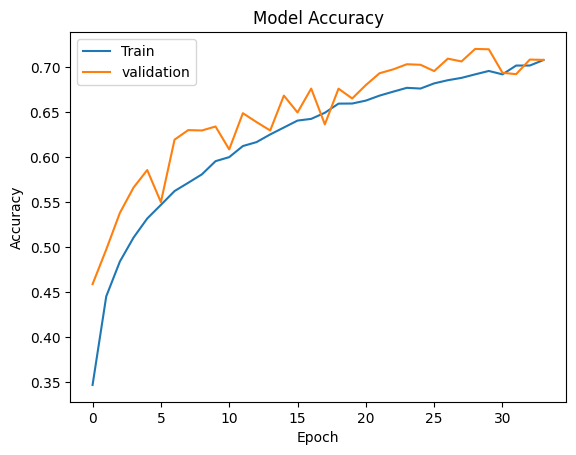

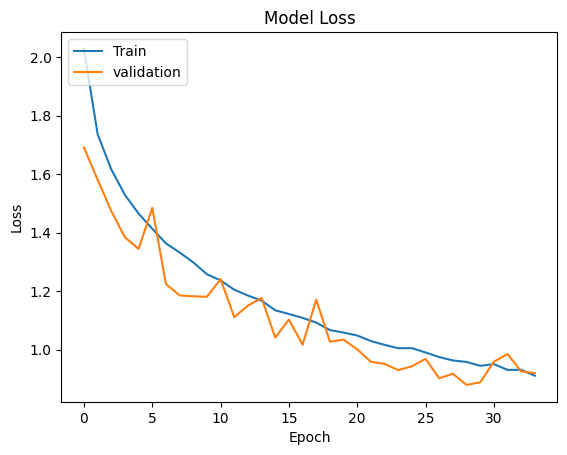

Predictions started....
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Accuracy :  0.7237

Confusion Matrix : 
[[664  19  55   4  66  10  27  22  75  58]
 [  2 852   3   3   1   0  20   7  21  91]
 [ 38   1 462  21 130  59 191  70  10  18]
 [  9   8  30 361  83 179 199  76  22  33]
 [  3   1  11  11 713  17 158  75  10   1]
 [  7   4  17  74  61 625  77 110   9  16]
 [  1   2   3  14  21   5 940   5   6   3]
 [  3   2  11  11  46  15  22 872   4  14]
 [ 17  26   9   5  16   3  18   6 871  29]
 [  9  48   2   5   3   3  22  12  19 877]]

Classification Report :
              precision    recall  f1-score   support

    Airplane       0.88      0.66      0.76      1000
  Automobile       0.88      0.85      0.87      1000
        Bird       0.77      0.46      0.58      1000
         Cat       0.71      0.36      0.48      1000
        Deer       0.63      0.71      0.67      1000
         Dog       0.68      0.62      0.65      1000
        Frog       0.56      0.94      0.70      1000
 

In [ ]:
print(f"Evaluation started....")
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)
    #plotting
print(f"Plotting started....")
plotting_metrics(history)
    #predictions
print(f"Predictions started....")
class_labels=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
model_prediction(best_model,x_test,y_test,class_labels)

Explainable AI Implementation

Starting LIME explanation...
Explaining sample 1/3...


  0%|          | 0/2000 [00:00<?, ?it/s]

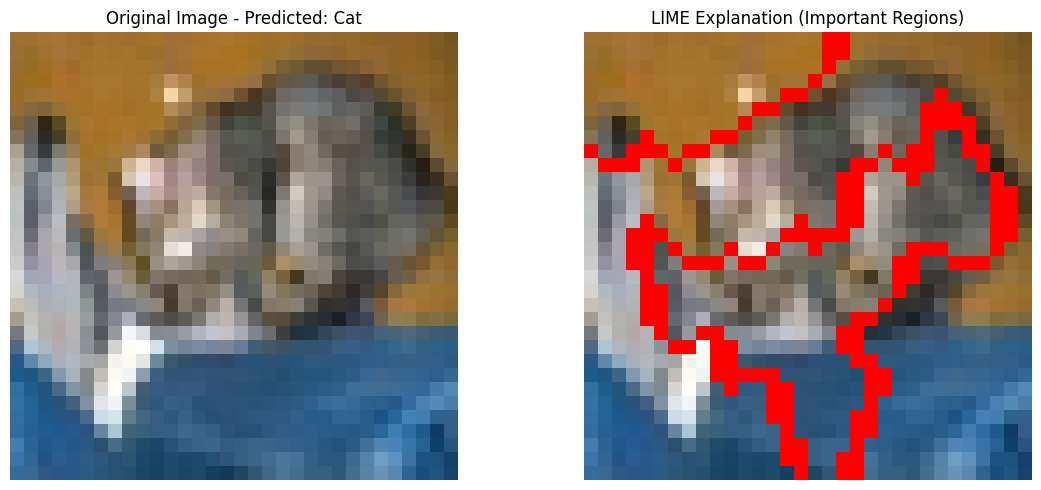

Prediction probabilities for sample 1:
  Airplane: 0.0012
  Automobile: 0.0009
  Bird: 0.0064
  Cat: 0.7430
  Deer: 0.0152
  Dog: 0.1110
  Frog: 0.0602
  Horse: 0.0005
  Ship: 0.0592
  Truck: 0.0023
--------------------------------------------------
Explaining sample 2/3...


  0%|          | 0/2000 [00:00<?, ?it/s]

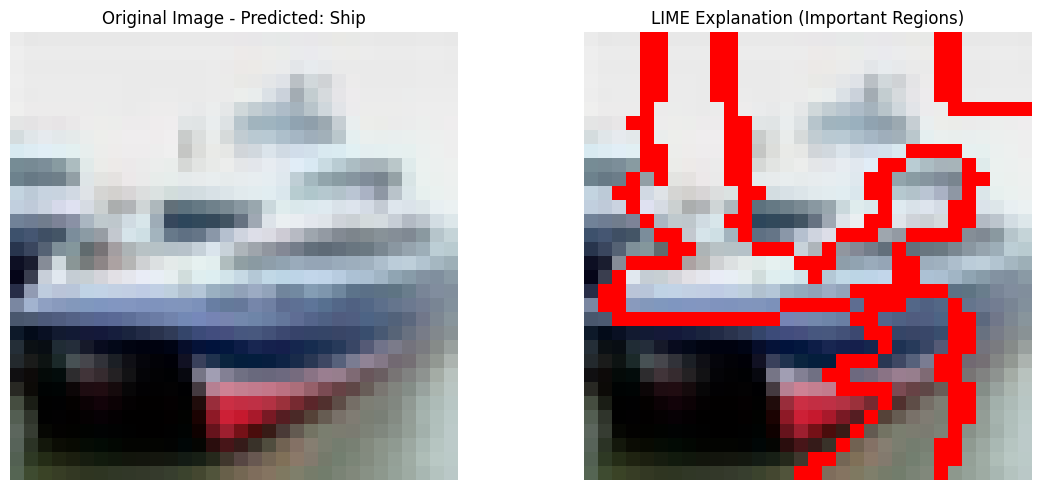

Prediction probabilities for sample 2:
  Airplane: 0.0009
  Automobile: 0.1371
  Bird: 0.0000
  Cat: 0.0000
  Deer: 0.0000
  Dog: 0.0000
  Frog: 0.0000
  Horse: 0.0000
  Ship: 0.8612
  Truck: 0.0008
--------------------------------------------------
Explaining sample 3/3...


  0%|          | 0/2000 [00:00<?, ?it/s]

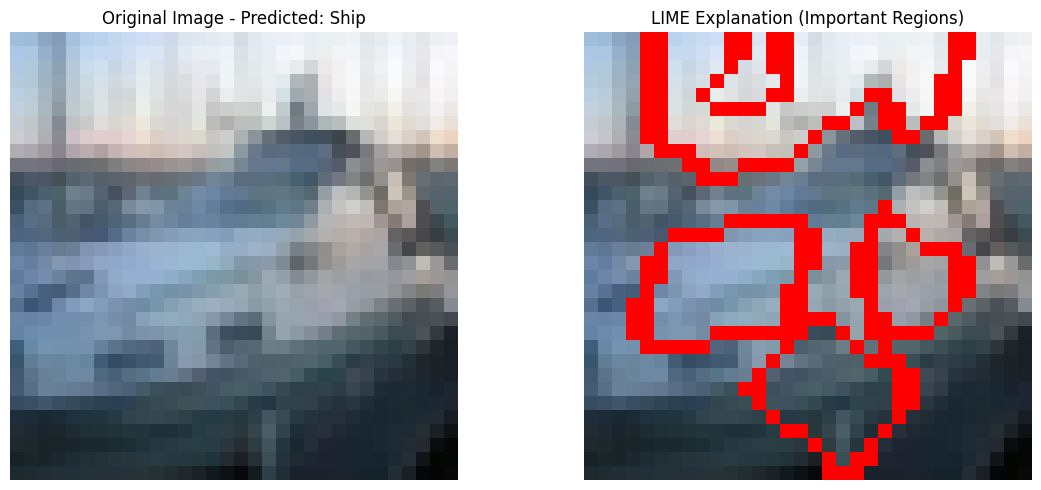

Prediction probabilities for sample 3:
  Airplane: 0.0008
  Automobile: 0.0125
  Bird: 0.0000
  Cat: 0.0000
  Deer: 0.0000
  Dog: 0.0000
  Frog: 0.0001
  Horse: 0.0000
  Ship: 0.9851
  Truck: 0.0014
--------------------------------------------------


In [ ]:
#explainable _ai
explainable_ai_lime(best_model,x_test,class_labels)